In [30]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import json
import os

In [2]:
grammatical_tasks = {
    'gpt_sv_agreement': { # (new_col, correct_col, wrong_col). new_col is generally the shared prefix of the two cols
        'simple': [('s', 'ss', 'sp'), ('p', 'pp', 'ps')], 
        'subjrelclause': [('ss', 'sss', 'ssp'), ('sp', 'sps', 'spp'), ('ps', 'psp', 'pss'), ('pp', 'ppp', 'pps')], 
        'sentcomp': [('ss', 'sss', 'ssp'), ('sp', 'sps', 'spp'), ('ps', 'psp', 'pss'), ('pp', 'ppp', 'pps')], # this one is a bit weird since the one that agrees is the second noun, order is second noun, first noun, verb
        'shortvpcoord': [('ss', 'sss', 'ssp'), ('pp', 'ppp', 'pps')], # only taking case where first verb correctly agrees
        'pp': [('ss', 'sss', 'ssp'), ('sp', 'sps', 'spp'), ('ps', 'psp', 'pss'), ('pp', 'ppp', 'pps')], 
        'objrelclausethat': [('ss', 'sss', 'ssp'), ('sp', 'sps', 'spp'), ('ps', 'psp', 'pss'), ('pp', 'ppp', 'pps')], 
        'objrelclausenothat': [('ss', 'sss', 'ssp'), ('sp', 'sps', 'spp'), ('ps', 'psp', 'pss'), ('pp', 'ppp', 'pps')], 
    }, 
    'gpt_anaphora': {
        'simple': [('s', 'ss', 'sp'), ('p', 'pp', 'ps')], 
        'sentcomp': [('ss', 'sss', 'ssp'), ('sp', 'sps', 'spp'), ('ps', 'psp', 'pss'), ('pp', 'ppp', 'pps')], # this one is a bit weird since the one that agrees is the second noun and psp means second noun is p, first noun is s, anaphor is p
        'objrelclausethat': [('ss', 'sss', 'ssp'), ('sp', 'sps', 'spp'), ('ps', 'psp', 'pss'), ('pp', 'ppp', 'pps')], 
        'objrelclausenothat': [('ss', 'sss', 'ssp'), ('sp', 'sps', 'spp'), ('ps', 'psp', 'pss'), ('pp', 'ppp', 'pps')], 
    }, 
}

In [3]:
def convert_to_col(col, fine_tuned=False): 
    col_name_split = ['SG' if c=='s' else 'PL' for c in col]
    if fine_tuned: 
        col_name_split.pop(0)
    return '_'.join(col_name_split)

In [4]:
def take_column_differences(df, sent_type, task, fine_tuned_number=None): 
    fine_tuned = fine_tuned_number is not None
    if fine_tuned: 
        fine_tuned_number = fine_tuned_number.lower()
        if fine_tuned_number not in ['sg', 'pl']: 
            raise ValueError('fine_tuned_number in take_column_differences is wrong: ' + str(fine_tuned_number))
    new_df = pd.DataFrame()
    for new_col, correct_col, wrong_col in grammatical_tasks[sent_type][task]: 
        correct_col_name = convert_to_col(correct_col, fine_tuned=fine_tuned)
        wrong_col_name = convert_to_col(wrong_col, fine_tuned=fine_tuned)
        if fine_tuned: 
            if new_col[0] != fine_tuned_number[0]: 
                continue
        new_df[new_col] = df[correct_col_name]-df[wrong_col_name]
    if fine_tuned: 
        new_df['model_name'] = df['model_name']
    else: 
        new_df['sent'] = df['sent']
    return new_df

In [37]:
# from https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    # https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ticklabel_fontsize = 14
    ax.set_xticklabels(col_labels, fontsize=ticklabel_fontsize)
    ax.set_yticklabels(row_labels, fontsize=ticklabel_fontsize)


    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True, 
                   left=False, labelleft=True)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [32]:
# https://stackoverflow.com/questions/50192121/custom-color-palette-intervals-in-seaborn-heatmap
def NonLinCdict(steps, hexcol_array):
    cdict = {'red': (), 'green': (), 'blue': ()}
    for s, hexcol in zip(steps, hexcol_array):
        rgb =matplotlib.colors.hex2color(hexcol)
        cdict['red'] = cdict['red'] + ((s, rgb[0], rgb[0]),)
        cdict['green'] = cdict['green'] + ((s, rgb[1], rgb[1]),)
        cdict['blue'] = cdict['blue'] + ((s, rgb[2], rgb[2]),)
    return cdict

In [44]:
def draw_heatmap(syn_df, sg_sem_df, pl_sem_df): 
    for i, (df, filename, supertitle) in enumerate([(syn_df,'./gpt2_syntactic_heatmap.png', 'Syntactic FSL: GPT-2'), (sg_sem_df,'./gpt2_wug_semantic_heatmap.png', 'Singular Semantic FSL: GPT-2'), (pl_sem_df, './gpt2_wuz_semantic_heatmap.png', 'Plural Semantic FSL: GPT-2')]): 
        if i==0: 
            fig = plt.figure(figsize=(8.5,7))
        elif i==1: 
            fig = plt.figure(figsize=(9,7))
        elif i==2: 
            fig = plt.figure(figsize=(10,7))
        ax = plt.gca()
        ax.set_title(supertitle, fontsize=15)
        
        if i==0: 
            kwargs = {'vmin': -0.5, 'vmax': 8.5}
            th = [0, 0.1, 0.2, 0.35, 1]
        else: 
            kwargs = {'vmin': -3.5, 'vmax': 5}
            th = [0, 0.25, 0.5, 0.75, 1]

        hc = ['#feffe2', '#d6efa2', '#76c679', '#238443', '#004629']
        cdict = NonLinCdict(th, hc)
        cm = LinearSegmentedColormap('colormap', cdict)

        im, cbar = heatmap(df, df.index.values, df.columns, ax=ax,
                        cmap=cm, cbar_kw = {'cmap': cm}, cbarlabel="Performance", **kwargs)
        
        texts = annotate_heatmap(im, valfmt="{x:.2f}", **{'fontsize': 13})

        fig.tight_layout()
        plt.savefig(filename)
        plt.show()

In [7]:
def run_plotting_pipeline():  
    """
    set retake_differences to true to always compute differences (do this if changing which differences to take)
    """
    def run_task(sent_type, task): 
        split_ind = sent_type.index('_')
        model = sent_type[:split_ind]
        sent_type_short = sent_type[split_ind+1:]
        sg_df = pd.read_csv('../transformer_evals/one_shot_consolidated_results/%s/sg/%s/%s.csv' % (model, sent_type_short, task))
        pl_df = pd.read_csv('../transformer_evals/one_shot_consolidated_results/%s/pl/%s/%s.csv' % (model, sent_type_short, task))
        # print(pl_df)
        # print(sg_df)
        # return
        sg_df = reorder_rows(sg_df, 'sg')
        pl_df = reorder_rows(pl_df, 'pl')
        # print(pl_df)
        # return
        sg_df = take_column_differences(sg_df, sent_type, task, fine_tuned_number='sg')
        pl_df = take_column_differences(pl_df, sent_type, task, fine_tuned_number='pl')
        new_sg_df = pd.DataFrame(columns=sg_df['model_name'].rename('Wug'))
        new_pl_df = pd.DataFrame(columns=pl_df['model_name'].rename('Wuz'))
        s_subcols = [s for s in sg_df.columns if s.startswith('s')]
        p_subcols = [s for s in pl_df.columns if s.startswith('p')]
        s_vals = [x for x in sg_df[s_subcols].mean(axis=1).T]
        p_vals = [x for x in pl_df[p_subcols].mean(axis=1).T]
        new_sg_df.loc[len(new_sg_df)] = s_vals
        new_pl_df.loc[len(new_pl_df)] = p_vals
        new_sg_df['task'] = ' '.join([sent_type_short, task])
        new_pl_df['task'] = ' '.join([sent_type_short, task])
        return new_sg_df, new_pl_df
    

    sg_df = pd.DataFrame()
    pl_df = pd.DataFrame()
    for sent_type in grammatical_tasks: 
        for task in grammatical_tasks[sent_type]: 
            new_sg, new_pl = run_task(sent_type, task)
            differences_filename = '../transformer_evals/%s/differences_data/%s.differences.csv' % (sent_type, task)

            # try: 
            #     df = pd.read_csv(differences_filename)
            # except FileNotFoundError as e: 
            #     df = pd.read_csv('../transformer_evals/%s/consolidated_data/%s.consolidated.csv' % (sent_type, task))
            #     df = take_column_differences(df, sent_type, task)
            #     df.to_csv(differences_filename, index=False)
            df = pd.read_csv(differences_filename)

            s_subcols = [s for s in df.columns if s.startswith('s') and 'freq' not in s]
            p_subcols = [s for s in df.columns if s.startswith('p') and 'freq' not in s]
            s_vals = [x for x in df[s_subcols].mean(axis=1).T]
            p_vals = [x for x in df[p_subcols].mean(axis=1).T]
            new_sg.insert(0, 'gpt2-xl-sg', np.mean(s_vals))
            new_pl.insert(0, 'gpt2-xl-pl', np.mean(p_vals))

            sg_df = sg_df.append(new_sg)
            pl_df = pl_df.append(new_pl)
            
    sg_df = sg_df.set_index('task')
    pl_df = pl_df.set_index('task')
    
    sg_df.drop('sv_agreement shortvpcoord', inplace=True)
    pl_df.drop('sv_agreement shortvpcoord', inplace=True)
    draw_heatmap(*subset_dfs(sg_df, pl_df))

In [39]:
syn_df_order = ['gpt2-xl-sg', 'gpt2-xl-pl', 'wug-base', 'wuz-base', 'wug-simple', 'wuz-simple', 'wug-pred-adj', 'wuz-pred-adj', 'wug-reflexive', 'wuz-reflexive']
sem_sg_subset = ['gpt2-xl', 'baseline', 'all-alone', 'unaccompanied', 'separated-entire', 'personally']
sem_pl_subset = ['gpt2-xl', 'baseline', 'unison', 'together', 'simultaneously', 'outnumbered', 'constituted', 'gathered']

def subset_dfs(sg_df, pl_df): 
    syn_sg = sg_df[[sg_df.columns[i] for i in range(5)]]
    syn_pl = pl_df[[pl_df.columns[i] for i in range(5)]]
    sem_sg = sg_df[[sg_df.columns[i] for i in range(2)] + [sg_df.columns[i] for i in range(5, len(sg_df.columns))]]
    sem_pl = pl_df[[pl_df.columns[i] for i in range(2)] + [pl_df.columns[i] for i in range(5, len(pl_df.columns))]]

    sem_sg_news = {}
    sem_pl_news = {}

    for col in sem_sg.columns: 
        if col.endswith('-new'): 
            sem_sg_news[col] = col[:-4]

    for col in sem_pl.columns: 
        if col.endswith('-new'): 
            sem_pl_news[col] = col[:-4]

    for newcol, oldcol in sem_sg_news.items(): 
        sem_sg.drop(oldcol, axis=1, inplace=True)

    for newcol, oldcol in sem_pl_news.items(): 
        sem_pl.drop(oldcol, axis=1, inplace=True)

    sem_sg.rename(columns=sem_sg_news, inplace=True)
    sem_pl.rename(columns=sem_pl_news, inplace=True)

    sg_np = syn_sg.to_numpy()
    pl_np = syn_pl.to_numpy()
    syn_np = (sg_np+pl_np)/2
    syn_df = pd.DataFrame(syn_np)
    syn_df.index = syn_sg.index
    syn_df.columns = ['gpt2-xl', 'baseline', 'simple', 'pred-adj', 'reflexive']
    sem_sg.columns = ['gpt2-xl', 'baseline', 'only', 'lone', 'sole', 'unaccompanied', 'all-alone', 'personally', 'separated-entire', 'lex-ndist-ncoll', 'world-ndist-ncoll', 'first', 'caught', 'wore-the', 'top-score', 'birth']
    sem_pl.columns = ['gpt2-xl', 'baseline', 'unison', 'exchanged', 'outnumbered', 'simultaneously', 'unanimously', 'side-by-side', 'gathered', 'constituted', 'formed', 'together', 'lex-dist', 'lex-coll', 'world-coll', 'all-over', 'throughout', 'around', 'lifted']
    sem_sg = sem_sg[sem_sg_subset]
    sem_pl = sem_pl[sem_pl_subset]

    return syn_df, sem_sg, sem_pl

In [9]:
def reorder_rows(df, number): 
    if number=='sg': 
        return df.reindex([11, 14,12,13, 24,23,15,25,18,26,21,28,17,20,27,16,19,22, 1,10,3,2,7,4,6,5,9,0,8])
    elif number=='pl': 
        return df.reindex([11, 2,0,1, 20,17,18,19,21,13,14,16,23,22,12,15, 6,5,9,10,7,4,8,3])
        pass
    else: 
        raise ValueError('invalid number argument: ', str(number))

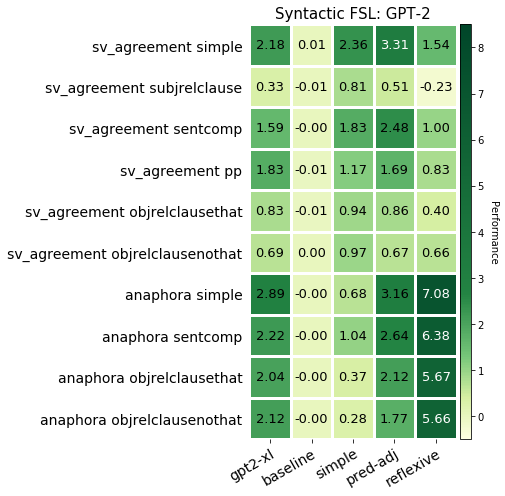

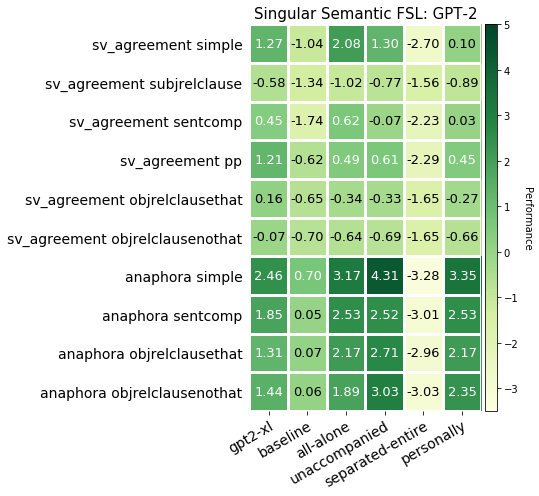

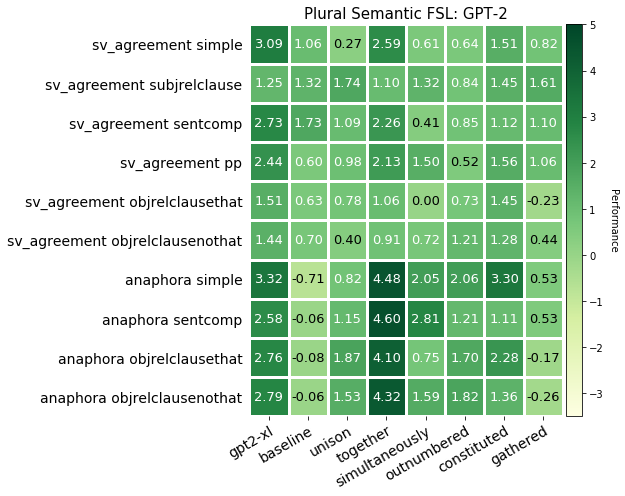

In [45]:
run_plotting_pipeline()
# plt.close("all")